In [7]:
import os
from typing import List, Tuple
from glasbey import create_palette
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
from seaborn import palplot
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import *

#### Display the base stimuli.

nColors: 15 - nShapes: 20


Text(0.5, 1.0, 'distinct colors')

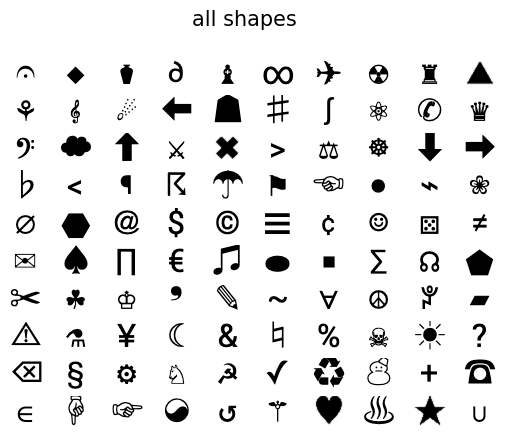

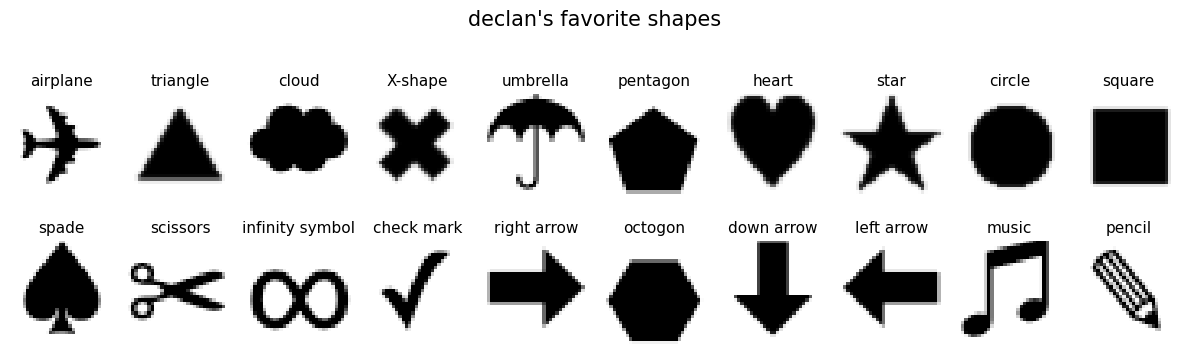

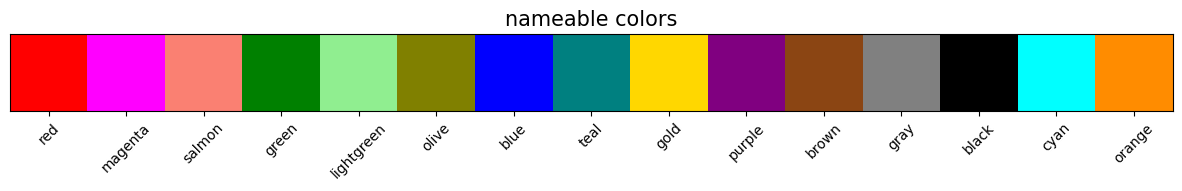

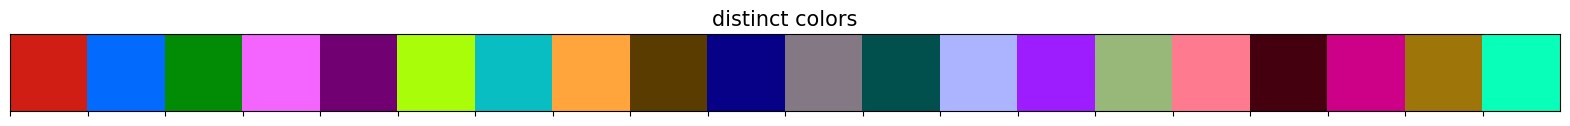

In [25]:
# plot all imgs
imgs = np.load('imgs.npy')
fig, axes = plt.subplots(10, 10)
for img, ax in zip(imgs, axes.ravel()):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
fig.suptitle('all shapes', fontsize=15)

# Plot declan's favorite shapes
shape_names = ['airplane', 'triangle', 'cloud', 'X-shape', 'umbrella', 'pentagon', 'heart', 'star', 'circle', 'square', 'spade', 'scissors', 'infinity symbol', 'check mark', 'right arrow', 'octogon', 'down arrow', 'left arrow', 'music', 'pencil']
shape_inds = [6, 9, 21, 24, 34, 59, 96, 98, 100, 101, 51, 60, 5, 85, 29, 41, 28, 13, 54, 64]
assert len(shape_inds) == len(shape_names), 'shape_inds and shape_names must have the same length'
fig, axes = plt.subplots(2, len(shape_inds)//2, figsize=(12, 4), tight_layout=True)
for i, ax in zip(shape_inds, axes.ravel()):
    ax.imshow(imgs[i], cmap='gray')
    ax.axis('off')
    ax.set_title(shape_names.pop(0), fontsize=11)
fig.suptitle('declan\'s favorite shapes', fontsize=15)

# plot a few distinguishable and (VLM) nameable mpl colors 
mpl_colors = ['red', 'magenta', 'salmon', 'green', 'lightgreen', 'olive', 'blue', 'teal', 'gold', 'purple', 'saddlebrown', 'gray', 'black', 'cyan', 'darkorange']
color_names = ['red', 'magenta', 'salmon', 'green', 'lightgreen', 'olive', 'blue', 'teal', 'gold', 'purple', 'brown', 'gray', 'black', 'cyan', 'orange']
print(f'nColors: {len(color_names)} - nShapes: {len(shape_inds)}')
palplot(mpl_colors)
plt.title('nameable colors', fontsize=15)
plt.xticks(np.arange(len(color_names)), color_names, rotation=45)

# plot a maximally distinguishable palette
n_colors = 20
palette = create_palette(n_colors, grid_size=256, grid_space='JCh')  # grid_size maximizes distinguishability and grid_space='JCh' is darker
palplot(palette)
plt.title('distinct colors', fontsize=15)

#### Define utility functions for generating simple trials containing 2D shapes (all in utils.py)

In [6]:
def place_shapes(shape_imgs: List[np.ndarray], 
                 img_size: int=32, 
                 canvas_size: int=256) -> Image.Image:
    '''
    Place all shapes on a canvas image.

    Parameters:
    shape_imgs (List[np.ndarray]): The shapes images to be placed on the canvas.
    img_size (int): The size of the shapes. Default is 32.
    '''
    # Define the canvas to draw images on, font, and drawing tool.
    canvas = np.ones((3, canvas_size, canvas_size), dtype=np.uint8) * 255
    canvas = np.transpose(canvas, (1, 2, 0))  # Transpose to (256x256x3) for PIL compatibility.
    canvas_img = Image.fromarray(canvas)
    # Add the shapes to the canvas.
    n_shapes = len(shape_imgs)
    positions = np.zeros([n_shapes, 2])
    for i, img in enumerate(shape_imgs):
        positions = paste_shape(img, positions, canvas_img, i, img_size=img_size)
    return canvas_img

def paste_shape(shape: np.ndarray, 
                positions: np.ndarray, 
                canvas_img: Image.Image, 
                i: int, 
                img_size: int = 40,
                canvas_size: int = 256) -> np.ndarray:
    '''
    Paste a shape onto a canvas image at a random position.

    Parameters:
    shape (np.ndarray): The shape to be pasted.
    positions (np.ndarray): The positions of the shapes on the canvas.
    canvas_img (Image.Image): The canvas image.
    i (int): The index of the current shape.
    img_size (int): The size of the shape. Default is 12.

    Returns:
    np.ndarray: The updated positions of the shapes on the canvas.
    '''
    img = Image.fromarray(np.transpose(shape, (1, 2, 0)))
    position = np.array(np.random.randint(0, 256-img_size, size=2)).reshape(1, -1)
    # Keep trying to find a position that is far enough from the other shapes.
    while np.any(np.linalg.norm(positions-position, axis=1) < img_size):
        position = np.array(np.random.randint(0, 256-img_size, size=2)).reshape(1, -1)
    canvas_img.paste(img, tuple(position.squeeze()))
    positions[i] = position
    return positions


def color_shape(img: np.ndarray, rgb: np.ndarray, bg_color: float = 1, all_black: bool = False) -> np.ndarray:
    '''
    Color a grayscale image with a given RGB code.

    Parameters:
    img (np.ndarray): The grayscale image.
    rgb (np.ndarray): The RGB code.
    bg_color (float): The background color. Default is 1.
    all_black (bool): Whether to color the image black. Default is False.

    Returns:
    np.ndarray: The colored image.
    '''
    if all_black:
        rgb = np.ones(3)
        return img.astype(np.uint8) * rgb.reshape((3,1,1))
    # Normalize the RGB code.
    rgb = rgb.astype(np.float32)
    if rgb.max() > 1:
        rgb /= rgb.max()  # normalize rgb code
    img /= img.max()  # normalize image
    colored_img = (1-img) * rgb.reshape((3,1,1))
    colored_img += img * bg_color
    return (colored_img * 255).astype(np.uint8)

#### Generate a simple counting task with black dots.

100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


Generated 2000 trials.


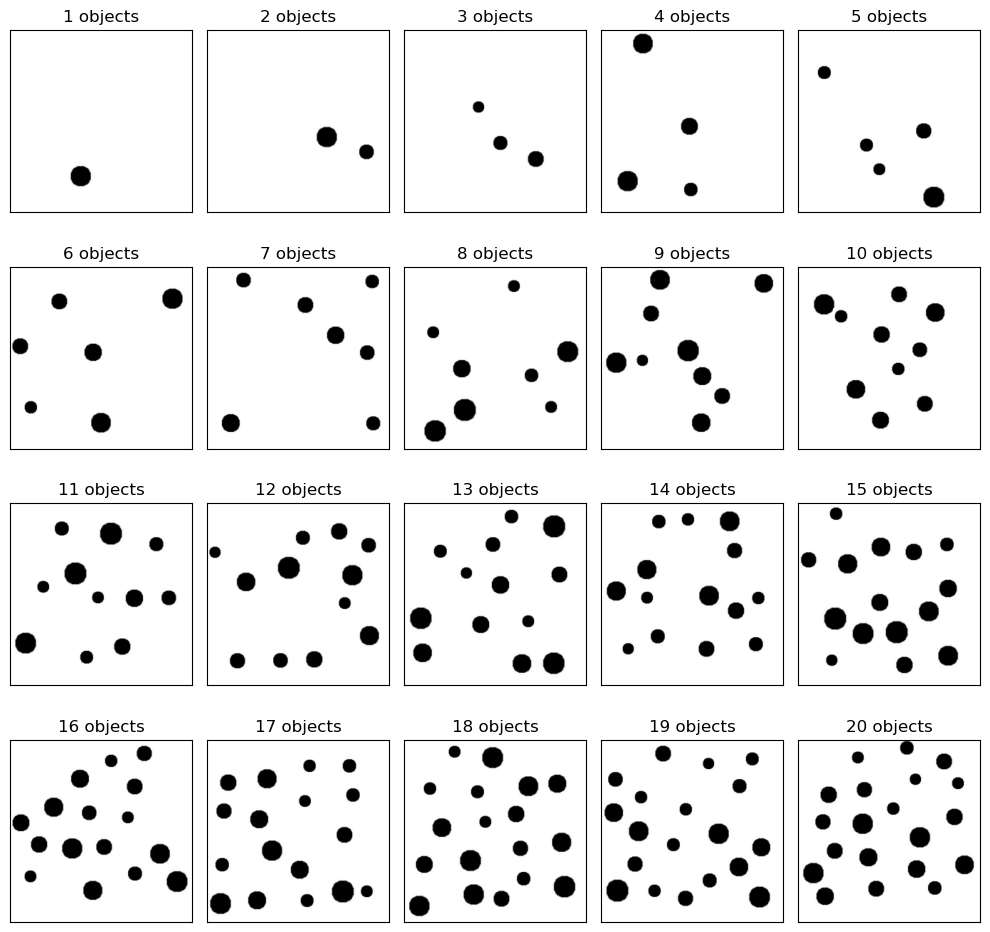

In [66]:
def make_counting_trial(shape_imgs: List[np.ndarray], 
                        colors: List[np.ndarray], 
                        size_range: Tuple[int, int]=(10, 20),
                        all_black: bool=False) -> Image.Image:
    '''
    Make a counting trial with shapes of different colors and sizes.

    Parameters:
    shape_imgs (List[np.ndarray]): The shapes to be placed on the canvas.
    colors (List[np.ndarray]): The colors of the shapes.
    size_range (Tuple[int, int]): The range of sizes for the shapes.
    '''
    sizes = np.random.randint(size_range[0], size_range[1], len(shape_imgs))
    colored_imgs = [color_shape(img.astype(np.float32), rgb, all_black=all_black) for img, rgb in zip(shape_imgs, colors)]
    resized_imgs = [resize(img, img_size=size) for img, size in zip(colored_imgs, sizes)]
    counting_trial = place_shapes(resized_imgs, img_size=max(sizes)+4) # +4 for padding
    return counting_trial

# Dataset parameters
n_objects = np.arange(1, 21)
shape_ind = 100 # circle
n_trials = 100
min_size = 25
max_size = 35

# Dataset generation
all_trials = []
imgs = np.load('imgs.npy')
metadata_df = pd.DataFrame(columns=['path', 'n_objects', 'response'])
for n in tqdm(n_objects):
    shapes = [imgs[shape_ind] for _ in range(n)]
    for i in range(n_trials):
        colors = np.tile([1,1,1], (n,1))
        trial = make_counting_trial(shapes, colors, size_range=(min_size, max_size), all_black=True)
        all_trials.append(trial)
print(f'Generated {len(all_trials)} trials.')

# Display some example trial images.
fig, axes = plt.subplots(4, 5, figsize=(8, 8), tight_layout=True)
sample_imgs = all_trials[::n_trials]
for i, (img, ax) in enumerate(zip(sample_imgs, axes.ravel())):
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{n_objects[i]} objects')

#### Generate a simple counting task with distinct colors and shapes.

100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


Generated 2000 trials.


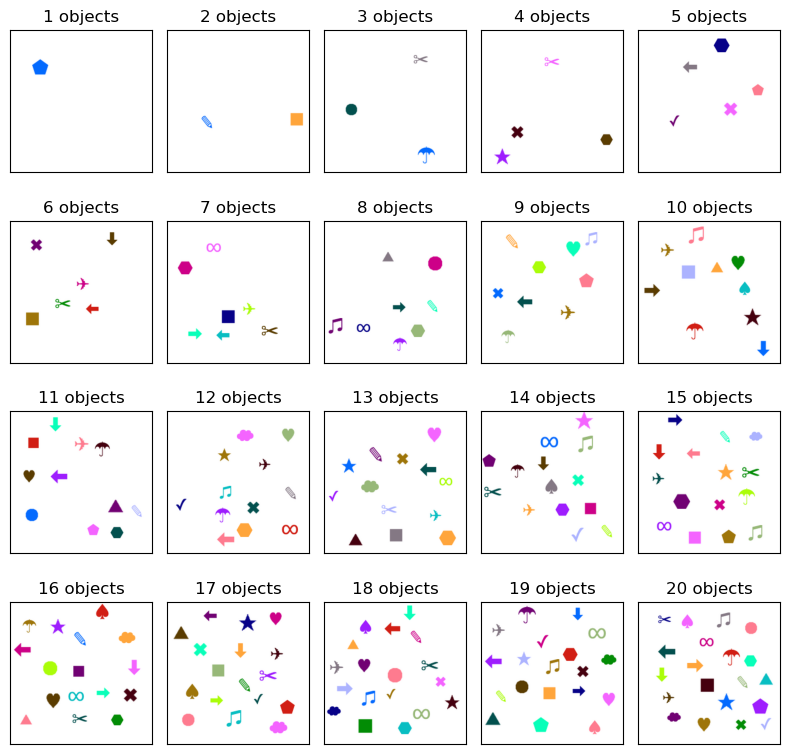

In [73]:
def make_counting_trial(shape_imgs: List[np.ndarray], 
                        colors: List[np.ndarray], 
                        size_range: Tuple[int, int]=(10, 20)) -> Image.Image:
    '''
    Make a counting trial with shapes of different colors and sizes.

    Parameters:
    shape_imgs (List[np.ndarray]): The shapes to be placed on the canvas.
    colors (List[np.ndarray]): The colors of the shapes.
    size_range (Tuple[int, int]): The range of sizes for the shapes.
    '''
    sizes = np.random.randint(size_range[0], size_range[1], len(shape_imgs))
    colored_imgs = [color_shape(img.astype(np.float32), rgb) for img, rgb in zip(shape_imgs, colors)]
    resized_imgs = [resize(img, img_size=size) for img, size in zip(colored_imgs, sizes)]
    counting_trial = place_shapes(resized_imgs, img_size=max(sizes)+4) # +4 for padding
    return counting_trial

# Dataset parameters
n_objects = np.arange(1, 21)
shape_inds = np.array([6, 9, 21, 24, 34, 59, 96, 98, 100, 101, 51, 60, 5, 85, 29, 41, 28, 13, 54, 64])
n_trials = 100
min_size = 25
max_size = 35
all_trials = []

imgs = np.load('imgs.npy')
imgs = imgs[shape_inds]
metadata_df = pd.DataFrame(columns=['path', 'n_objects', 'response'])
palette = create_palette(palette_size=max(n_objects), grid_size=256, grid_space='JCh')
rgb_colors = np.array([mcolors.hex2color(color) for color in palette])
for n in tqdm(n_objects):
    for i in range(n_trials):
        shape_inds = np.random.choice(len(imgs), n, replace=False)
        color_inds = np.random.choice(len(rgb_colors), n, replace=False)
        colors = rgb_colors[color_inds]
        shapes = imgs[shape_inds]
        trial = make_counting_trial(shapes, colors, size_range=(min_size, max_size))
        all_trials.append(trial)
print(f'Generated {len(all_trials)} trials.')

# Display some example trial images.
fig, axes = plt.subplots(4, 5, figsize=(8, 8), tight_layout=True)
sample_imgs = all_trials[::n_trials]
for i, (img, ax) in enumerate(zip(sample_imgs, axes.ravel())):
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{n_objects[i]} objects')

#### Generate a simple scene description task.

100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


Text(0.5, 0.98, 'low entropy => high entropy')

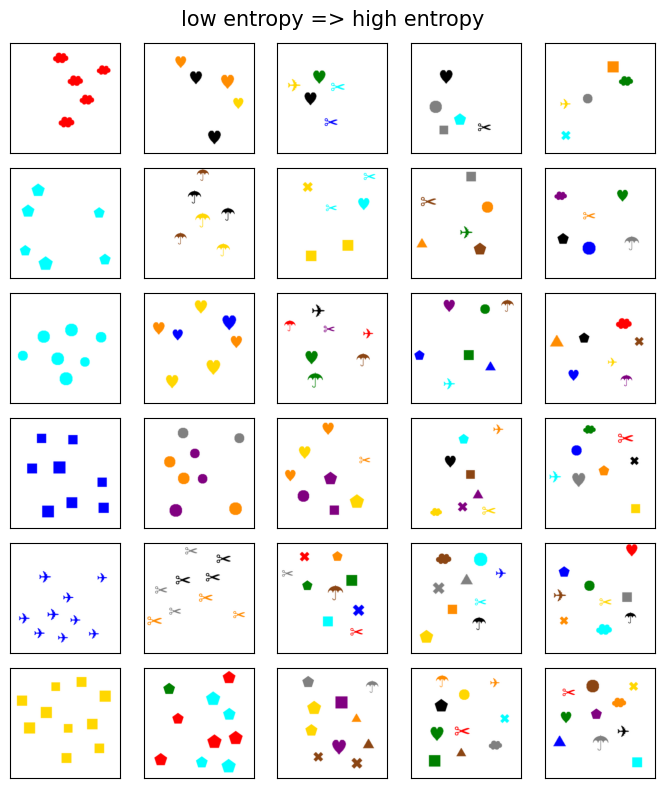

In [103]:
from itertools import product
from random import randint

def make_binding_trial(shapes: np.ndarray, 
                color_names: np.ndarray,
                shape_names: List[str], 
                n_objects: int = 5, 
                n_shapes: int = 5, 
                n_colors: int = 5, 
                min_size: int = 28,
                max_size: int = 40) -> Tuple[Image.Image, List[dict]]:
    # sample the shapes and colors of objects to include in the trial.
    sizes = np.random.randint(min_size, max_size, n_objects)
    unique_shape_inds = np.random.choice(len(shapes), n_shapes, replace=False) # sample the unique shapes for the current trial.
    shape_inds = np.concatenate([unique_shape_inds, np.random.choice(unique_shape_inds, n_objects-n_shapes, replace=True)])
    unique_color_inds = np.random.choice(len(color_names), n_colors, replace=False)  # sample the unique colors for the current trial.
    color_inds = np.concatenate([unique_color_inds, np.random.choice(unique_color_inds, n_objects-n_colors, replace=True)])
    shape_imgs = shapes[shape_inds]
    color_names = color_names[color_inds]
    object_features = [{'shape': shape_names[shape], 'color': color} for shape, color in zip(shape_inds, color_names)]
    # recolor and resize the shapes.
    rgb_codes = np.array([mcolors.to_rgba(color)[:-1] for color in color_names]) # convert the colors to RGB format.
    colored_imgs = [color_shape(img.astype(np.float32), rgb) for img, rgb in zip(shape_imgs, rgb_codes)]
    resized_imgs = [resize(img, img_size=size) for img, size in zip(colored_imgs, sizes)]
    counting_trial = place_shapes(resized_imgs, img_size=max(sizes)+10) # +10 for padding
    return counting_trial, object_features

# Dataset parameters
n_objects = np.arange(5,11)
shape_inds = np.array([6, 9, 21, 24, 34, 60, 96, 100, 101, 59])
color_names = np.array(['black', 'gray', 'red', 'blue', 'green', 'saddlebrown', 'purple', 'cyan', 'gold', 'darkorange'])
shape_names = np.array(['airplane', 'triangle', 'cloud', 'cross', 'umbrella', 'scissors', 'heart', 'circle', 'square', 'pentagon'])
n_trials = 200
min_size = 28
max_size = 40
all_trials = []

# Store trial metadata in a useable format.
metadata_df = pd.DataFrame(columns=['n_objects', 'n_shapes', 'n_colors', 'n_features', 'features'], dtype=object)
imgs = np.load('imgs.npy')
imgs = imgs[shape_inds]
for n in tqdm(n_objects):
    # Generate all unique ways to have n objects with n_shapes and n_colors
    task_conditions = list(product(range(1, n+1), range(1, n+1)))

    # Count the total number of features for each unique condition.
    condition_feature_counts = np.vstack(task_conditions).sum(axis=1) 

    # Ensure that there are an equal number of trials for each task condition.
    counts, count_freq = np.unique(condition_feature_counts, return_counts=True)

    # For each unique way of having n_shapes and n_colors, generate n_trials//n_ways_to_get_n_features trials.
    for n_features, (n_shapes, n_colors) in zip(condition_feature_counts, task_conditions):
        n_trials = int(np.ceil(n_trials / count_freq[counts == n_features][0]))

        # Generate n trials for the current unique way of having n_shapes and n_colors.
        for i in range(n_trials):
            trial, features = make_binding_trial(imgs, color_names, shape_names, n, n_shapes, n_colors, min_size=min_size, max_size=max_size)
            row = {'n_objects': n, 
                   'n_shapes': n_shapes, 
                   'n_colors': n_colors, 
                   'n_features': n_features,
                   'features': features}
            metadata_df = metadata_df._append(row, ignore_index=True)
            all_trials.append(trial)

# Display some example trial images.
fig, axes = plt.subplots(len(n_objects), 5, figsize=(7, 8), tight_layout=True, sharex=True, sharey=True)
for i, n in enumerate(n_objects):
    # Sample 5 task conditions with increasing entropy.
    task_conditions = np.array(list(product(range(1, n+1), range(1, n+1))))
    inds = np.array([0, 2, len(task_conditions)//2+randint(0,4), -3, -1]) # some representative task indices
    task_conditions = task_conditions[inds]
    for j, (n_shapes, n_colors) in enumerate(task_conditions):
        trial_idx = (metadata_df['n_objects'] == n) & (metadata_df['n_shapes'] == n_shapes) & (metadata_df['n_colors'] == n_colors)
        trial_img = all_trials[trial_idx.idxmax()]
        ax = axes[i, j]
        ax.imshow(trial_img)
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle('low entropy => high entropy', fontsize=15)